<a href="https://colab.research.google.com/github/oluwafemidiakhoa/Mindserach/blob/master/Weather_RoadNg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Load Dataset

In [44]:
import zipfile
import os

# Define the paths to the zip files and the directory to extract them to
zip_file_path_weather = '/content/Nigeria_weather.zip'
zip_file_path_traffic = '/content/Nigerian.zip'
extract_dir_weather = '/content/Nigeria_weather_data/'
extract_dir_traffic = '/content/Nigerian_data/'

# Extract the contents of the weather zip file
with zipfile.ZipFile(zip_file_path_weather, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_weather)

# Extract the contents of the traffic zip file
with zipfile.ZipFile(zip_file_path_traffic, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_traffic)

# List the extracted files from both zip files
extracted_files_weather = os.listdir(extract_dir_weather)
extracted_files_traffic = os.listdir(extract_dir_traffic)

extracted_files_weather, extracted_files_traffic


(['nigeria_cities_weather_data.csv'],
 ['Nigerian_Road_Traffic_Crashes_2020_2024.csv'])

##Checking Data for insight

In [45]:
import pandas as pd

# Load both datasets
weather_data_path = '/content/Nigeria_weather_data/nigeria_cities_weather_data.csv'
crash_data_path = '/content/Nigerian_data/Nigerian_Road_Traffic_Crashes_2020_2024.csv'

# Load datasets into pandas dataframes
weather_df = pd.read_csv(weather_data_path)
crash_df = pd.read_csv(crash_data_path)

# Display basic info and a few rows of both datasets to understand their structure
weather_df_info = weather_df.info()
crash_df_info = crash_df.info()

# Displaying the first few rows of both datasets
weather_df_head = weather_df.head()
crash_df_head = crash_df.head()

print(weather_df_info, crash_df_info)
print(weather_df_head, crash_df_head)

# Map cities to states using the 'region' column in the weather dataset
weather_df['State'] = weather_df['region']  # Renaming 'region' to 'State' to align with crash data

# Convert 'date' column in weather data to datetime format and extract the quarter for aggregation
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['Quarter'] = weather_df['date'].dt.to_period('Q')

# Aggregate weather data by State and Quarter, calculating mean values for weather metrics
weather_aggregated = weather_df.groupby(['State', 'Quarter']).agg({
    'temp': 'mean',
    'humidity': 'mean',
    'wind_speed': 'mean',
    'cloud': 'mean'
}).reset_index()

# Standardize the quarter format to match the crash data
weather_aggregated['Quarter'] = weather_aggregated['Quarter'].astype(str)
weather_aggregated['Quarter'] = weather_aggregated['Quarter'].str.replace('2024Q1', 'Q1 2024')

# Filter the crash data to include only the states available in the weather dataset
crash_filtered_df = crash_df[crash_df['State'].isin(weather_aggregated['State'].unique())]

# Merge the crash data with the aggregated weather data on 'State' and 'Quarter'
combined_df = pd.merge(crash_filtered_df, weather_aggregated, on=['State', 'Quarter'], how='inner')

# Display the combined dataset
print(combined_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22541 entries, 0 to 22540
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       22541 non-null  object 
 1   city          22541 non-null  object 
 2   latitude      22541 non-null  float64
 3   longitude     22541 non-null  float64
 4   temp          22541 non-null  float64
 5   temp_min      22541 non-null  float64
 6   temp_max      22541 non-null  float64
 7   pressure      22541 non-null  int64  
 8   humidity      22541 non-null  int64  
 9   sea_level     22541 non-null  int64  
 10  ground_level  22541 non-null  int64  
 11  wind_speed    22541 non-null  float64
 12  wind_degree   22541 non-null  int64  
 13  sunrise       22541 non-null  object 
 14  sunset        22541 non-null  object 
 15  timezone      22541 non-null  int64  
 16  cloud         22541 non-null  int64  
 17  description   22541 non-null  object 
 18  region        22541 non-nu

## Step 1: Exploratory Data Analysis and Feature Importance Using XGBoost

## Step 1: Exploratory Data Analysis and Feature Importance Using XGBoost

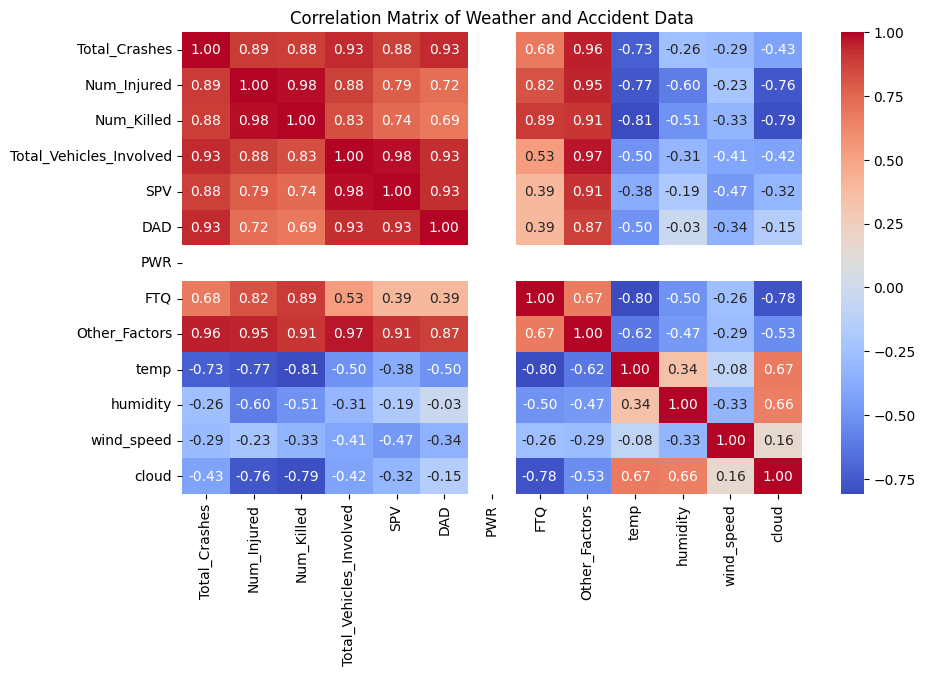

XGBoost RMSE: 91.44083584978024
XGBoost R2 Score: -1336.828233745033


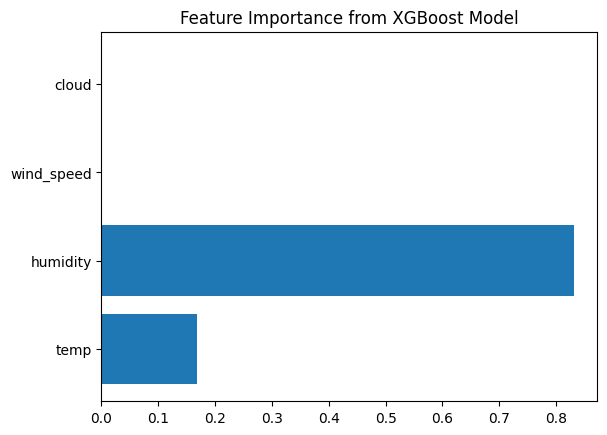

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Exploratory Data Analysis (EDA)
# Remove non-numeric columns before calculating correlation matrix
numeric_df = combined_df.select_dtypes(include=['number'])

# Checking correlations between weather variables and traffic accidents
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Weather and Accident Data')
plt.show()

# Step 2: Prepare data for model training
X = combined_df[['temp', 'humidity', 'wind_speed', 'cloud']]
y = combined_df['Total_Crashes']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: XGBoost Model for Feature Importance and Accident Prediction
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5)
xgb_model.fit(X_train, y_train)

# Predict on test data and evaluate the model
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {rmse}")
print(f"XGBoost R2 Score: {r2}")

# Plotting feature importance
xgb_importance = xgb_model.feature_importances_
plt.barh(X.columns, xgb_importance)
plt.title('Feature Importance from XGBoost Model')
plt.show()


## 2. Explaining Predictions Using SHAP
We use SHAP to explain the predictions made by the XGBoost model, helping us understand which weather variables are most responsible for predicting road accidents.

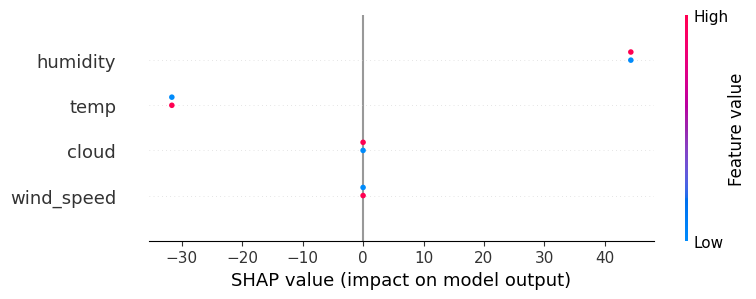

In [54]:
import shap

# Step 1: Create SHAP explainer for XGBoost
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Step 2: Plot SHAP summary to explain model predictions
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


## 3. Training an LSTM Model for Time-Series Forecasting
The LSTM model will be used for time-series forecasting, capturing sequential patterns in the weather data to predict future road accidents.

In [55]:
# Importing necessary libraries for LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Assuming X_lstm and y_lstm are prepared with sequential data (reshape as needed)
# Reshaping the data for LSTM (LSTM expects 3D input: [samples, time steps, features])
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

# Building the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))  # Output layer for predicting the number of crashes
lstm_model.compile(optimizer='adam', loss='mse')

# Training the LSTM model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32)

# Making predictions with the LSTM model
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluating LSTM model performance
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
print(f"LSTM RMSE: {rmse_lstm}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 12963.8037
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 12795.7061
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 12627.8701
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 12465.9658
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 12304.4336
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12143.6201
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 11984.2393
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 11832.8125
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 11680.5957
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 11526.5820
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 11369.6719
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 11209.0723
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 11044.8271
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 10878.1309
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
LSTM RMSE: 21.20424621423744


## 4. Risk Scoring Based on Weather Data
This function calculates a risk score based on current weather conditions, which can be used in real-time systems for predicting accident risk.

In [56]:
# Function to calculate risk score based on weather data
def risk_score(temp, humidity, wind_speed, cloud):
    # Weighted sum based on feature importance
    return 0.4 * temp + 0.3 * humidity + 0.2 * wind_speed + 0.1 * cloud

# Example weather data
example_weather = {'temp': 32, 'humidity': 70, 'wind_speed': 12, 'cloud': 85}

# Calculating the risk score
current_risk_score = risk_score(**example_weather)
print(f"Current Risk Score: {current_risk_score}")


Current Risk Score: 44.699999999999996


In [ ]:
import requests

# Example of fetching real-time weather data from an API
api_key = "your_api_key"
city = "Lagos"
url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}"

response = requests.get(url)
weather_data = response.json()

# Extract weather conditions from the API response
current_temp = weather_data['main']['temp']
current_humidity = weather_data['main']['humidity']
current_wind_speed = weather_data['wind']['speed']
current_cloud = weather_data['clouds']['all']

# Calculate real-time risk score
real_time_score = risk_score(current_temp, current_humidity, current_wind_speed, current_cloud)
print(f"Real-Time Risk Score: {real_time_score}")